In [1]:
pip install ucimlrepo


In [2]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
student_performance = fetch_ucirepo(id=320)

# data (as pandas dataframes)
X = student_performance.data.features
y = student_performance.data.targets

# metadata
print(student_performance.metadata)

# variable information
print(student_performance.variables)


{'uci_id': 320, 'name': 'Student Performance', 'repository_url': 'https://archive.ics.uci.edu/dataset/320/student+performance', 'data_url': 'https://archive.ics.uci.edu/static/public/320/data.csv', 'abstract': 'Predict student performance in secondary education (high school). ', 'area': 'Social Science', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 649, 'num_features': 30, 'feature_types': ['Integer'], 'demographics': ['Sex', 'Age', 'Other', 'Education Level', 'Occupation'], 'target_col': ['G1', 'G2', 'G3'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2008, 'last_updated': 'Fri Jan 05 2024', 'dataset_doi': '10.24432/C5TG7T', 'creators': ['Paulo Cortez'], 'intro_paper': {'ID': 360, 'type': 'NATIVE', 'title': 'Using data mining to predict secondary school student performance', 'authors': 'P. Cortez, A. M. G. Silva', 'venue': 'Proceedings of 5th Annual Future Business Technolo

正在載入資料...
資料集大小: (395, 33)
缺失值數量: 0
資料前處理完成。
------------------------------
已儲存相關性分析圖表: correlation_heatmap.png

開始進行監督式學習 (Random Forest)...
監督式學習報告：
              precision    recall  f1-score   support

           0       0.82      0.20      0.32        46
           1       0.66      0.97      0.78        73

    accuracy                           0.67       119
   macro avg       0.74      0.58      0.55       119
weighted avg       0.72      0.67      0.60       119

已儲存特徵重要性圖表: feature_importance.png

開始進行非監督式學習 (K-Means)...
已儲存分群結果圖表: cluster_result.png
------------------------------
所有分析完成。請查看資料夾中的 PNG 圖片檔以放入報告。


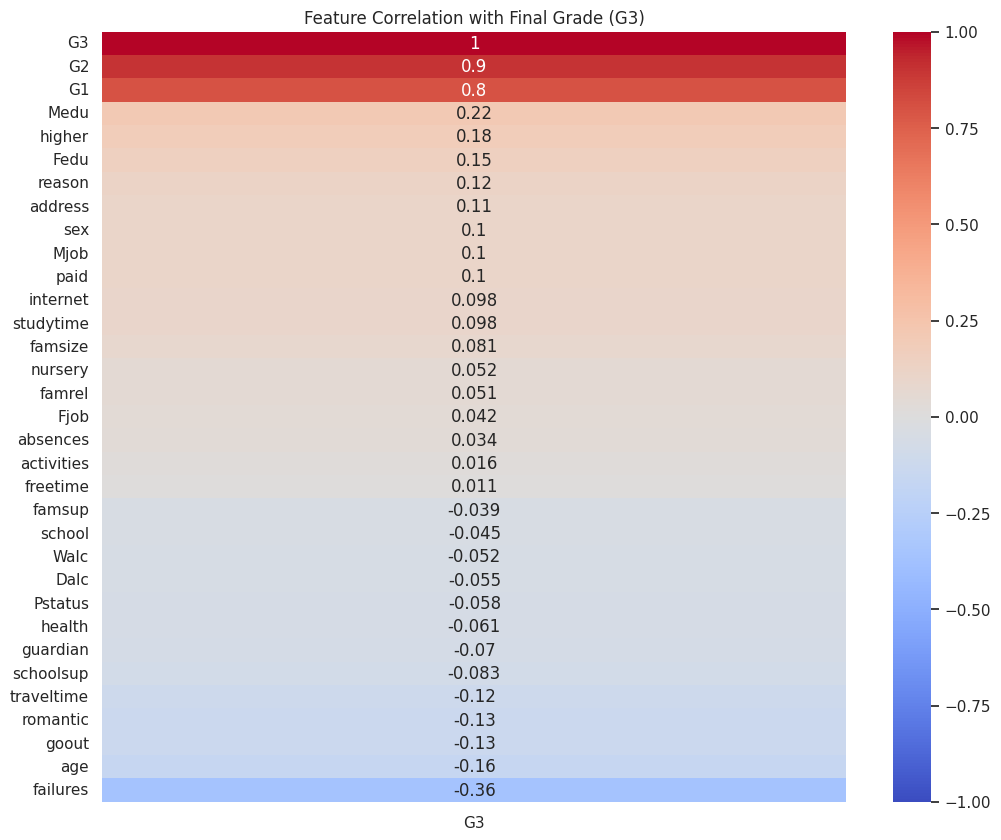

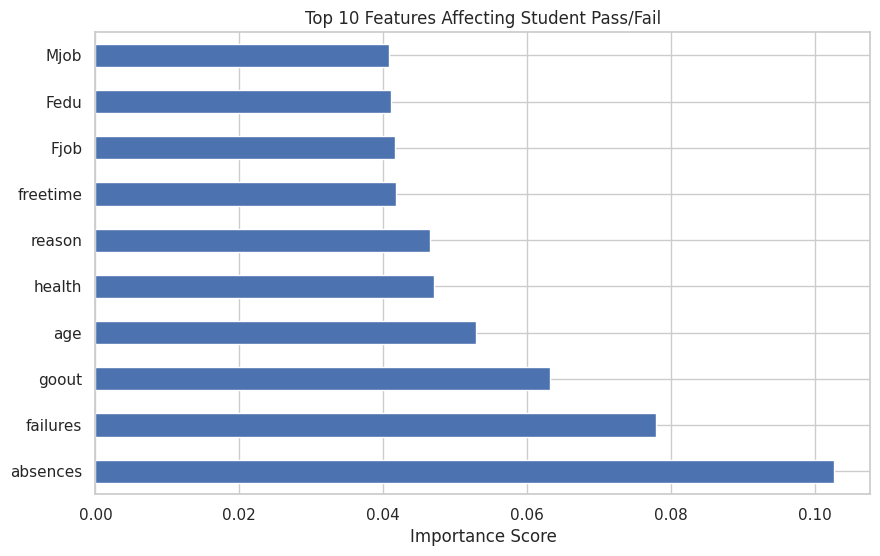

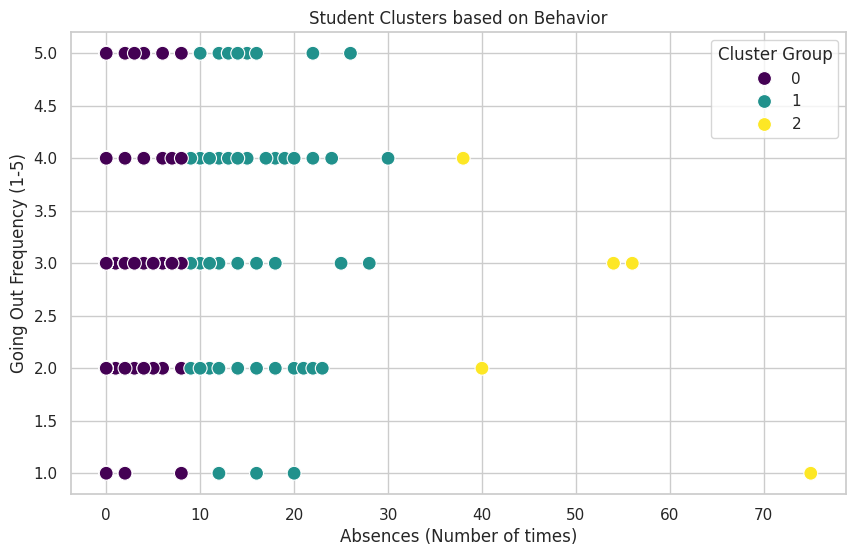

In [6]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# 設定圖表風格
sns.set(style="whitegrid")

# ---------------------------------------------------------
# 1. 資料載入與前處理
# ---------------------------------------------------------
print("正在載入資料...")
# 注意：UCI 的這個 CSV 使用分號 ';' 作為分隔符號，而非逗號
df = pd.read_csv('student-mat.csv', sep=';')

# 檢查是否有缺失值
print(f"資料集大小: {df.shape}")
print(f"缺失值數量: {df.isnull().sum().sum()}")

# 將非數值的類別資料 (如 'yes'/'no', 'F'/'M') 轉換為數值，以便模型分析
# 使用 Label Encoding 簡單處理
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

print("資料前處理完成。")
print("-" * 30)

# ---------------------------------------------------------
# 2. 資料探索 (EDA) - 產出關聯性熱圖
# ---------------------------------------------------------
plt.figure(figsize=(12, 10))
# 計算相關係數矩陣
correlation_matrix = df.corr()
# 繪製熱圖，只顯示相關性較高的部分以避免圖表太亂
sns.heatmap(correlation_matrix[['G3']].sort_values(by='G3', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation with Final Grade (G3)')
plt.savefig('correlation_heatmap.png') # 儲存圖片供報告使用
print("已儲存相關性分析圖表: correlation_heatmap.png")
#

# ---------------------------------------------------------
# 3. 監督式學習：預測學生是否及格 (Pass/Fail)
# ---------------------------------------------------------
print("\n開始進行監督式學習 (Random Forest)...")

# 定義目標：G3 >= 10 為及格 (1)，否則為不及格 (0)
df['passed'] = df['G3'].apply(lambda x: 1 if x >= 10 else 0)

# 特徵選擇：移除成績欄位 (G1, G2, G3) 避免資料洩漏，我們想用行為預測結果
# 如果你想保留 G1, G2 來預測 G3，可以把下方 drop 中的 G1, G2 拿掉
X = df.drop(['G1', 'G2', 'G3', 'passed'], axis=1)
y = df['passed']

# 切分訓練集與測試集 (70% 訓練, 30% 測試)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 建立隨機森林模型
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 預測
y_pred = rf_model.predict(X_test)

# 輸出結果
print("監督式學習報告：")
print(classification_report(y_test, y_pred))

# 繪製特徵重要性 (Feature Importance)
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Features Affecting Student Pass/Fail')
plt.xlabel('Importance Score')
plt.savefig('feature_importance.png')
print("已儲存特徵重要性圖表: feature_importance.png")

# ---------------------------------------------------------
# 4. 非監督式學習：學生分群 (K-Means Clustering)
# ---------------------------------------------------------
print("\n開始進行非監督式學習 (K-Means)...")

# 選取用於分群的特徵 (例如：學習時間、外出頻率、缺席數、健康狀況)
cluster_features = df[['studytime', 'goout', 'absences', 'health']]

# 建立 K-Means 模型 (假設分為 3 群)
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(cluster_features)

# 視覺化分群結果 (以 '缺席數' 和 '外出頻率' 為例)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='absences', y='goout', hue='cluster', palette='viridis', s=100)
plt.title('Student Clusters based on Behavior')
plt.xlabel('Absences (Number of times)')
plt.ylabel('Going Out Frequency (1-5)')
plt.legend(title='Cluster Group')
plt.savefig('cluster_result.png')
print("已儲存分群結果圖表: cluster_result.png")
#

print("-" * 30)
print("所有分析完成。請查看資料夾中的 PNG 圖片檔以放入報告。")

In [7]:
# 1. 載入必要套件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 2. 讀取資料
df = pd.read_csv('student-mat.csv', sep=';')

# 3. 資料前處理：把所有文字欄位轉成數字
le = LabelEncoder()
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col])

print("資料準備完成！")
df.head() # 顯示前五筆確認一下

資料準備完成！


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,0,18,1,0,0,4,4,0,4,...,4,3,4,1,1,3,6,5,6,6
1,0,0,17,1,0,1,1,1,0,2,...,5,3,3,1,1,3,4,5,5,6
2,0,0,15,1,1,1,1,1,0,2,...,4,3,2,2,3,3,10,7,8,10
3,0,0,15,1,0,1,4,2,1,3,...,3,2,2,1,1,5,2,15,14,15
4,0,0,16,1,0,1,3,3,2,2,...,4,3,2,1,2,5,4,6,10,10


=== 監督式學習結果報告 ===
              precision    recall  f1-score   support

           0       0.73      0.30      0.42        27
           1       0.72      0.94      0.82        52

    accuracy                           0.72        79
   macro avg       0.72      0.62      0.62        79
weighted avg       0.72      0.72      0.68        79

混淆矩陣 (Confusion Matrix):
[[ 8 19]
 [ 3 49]]


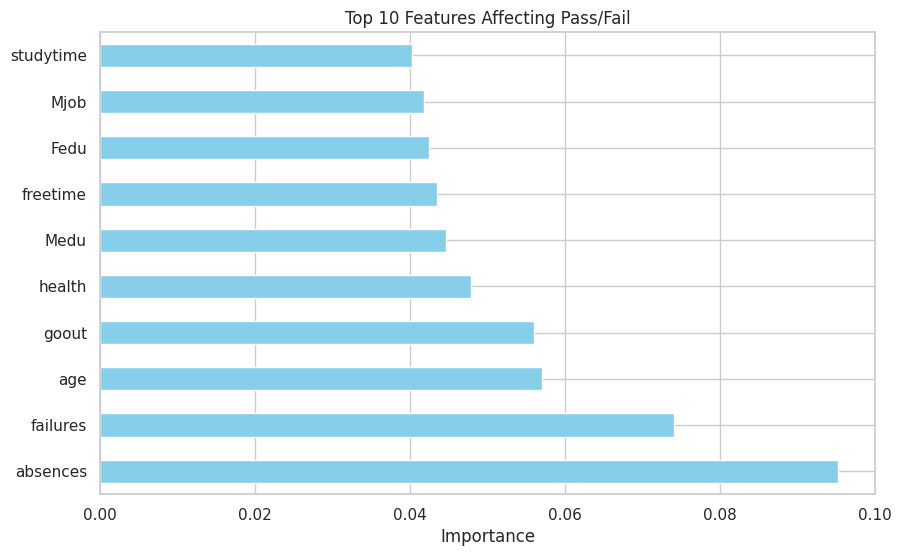

In [8]:
# --- 監督式學習：預測及格與否 ---

# 1. 定義問題：G3 >= 10 為及格 (1)，否則為不及格 (0)
# 我們把這個新欄位叫 'passed'
y = df['G3'].apply(lambda x: 1 if x >= 10 else 0)

# 2. 選擇特徵 (X)
# 我們移除 'G3' (答案) 和 'G1', 'G2' (因為段考成績太準了，會掩蓋其他生活習慣的影響)
X = df.drop(['G1', 'G2', 'G3'], axis=1)

# 3. 切分訓練集 (80%) 與測試集 (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. 建立並訓練模型 (隨機森林)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 5. 預測結果
y_pred = rf.predict(X_test)

# 6. 印出文字報告 (包含準確率 Accuracy)
print("=== 監督式學習結果報告 ===")
print(classification_report(y_test, y_pred))
print("混淆矩陣 (Confusion Matrix):")
print(confusion_matrix(y_test, y_pred))

# 7. 畫圖：哪些因素最影響及格？ (Feature Importance)
plt.figure(figsize=(10, 6))
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.nlargest(10).plot(kind='barh', color='skyblue') # 只畫前10名
plt.title('Top 10 Features Affecting Pass/Fail')
plt.xlabel('Importance')
plt.show() # 記得截這張圖放在報告裡

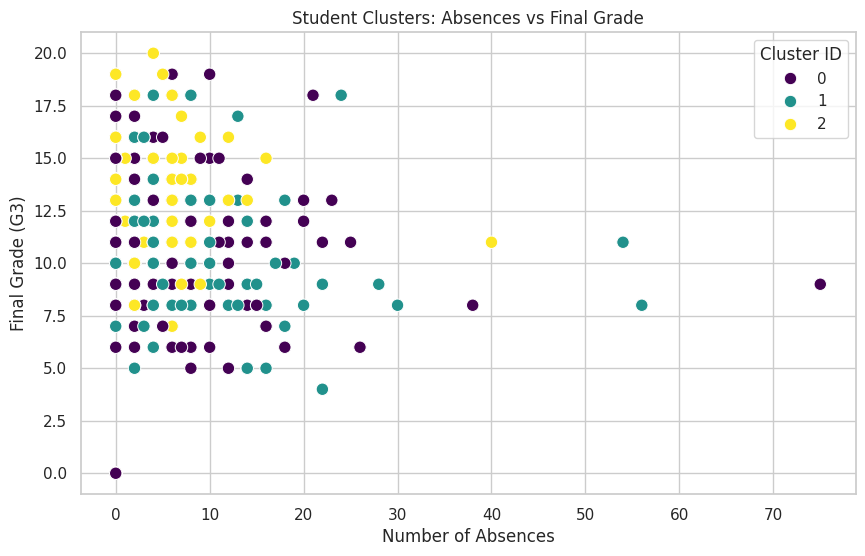

=== 各群體的平均特徵 ===
             Dalc      Walc     goout  absences  studytime         G3
cluster                                                              
0        1.090452  1.693467  2.753769  5.105528   1.693467  10.246231
1        2.472727  3.890909  3.954545  7.927273   1.672727   9.927273
2        1.116279  1.627907  2.848837  4.267442   3.290698  11.430233


In [9]:
# --- 非監督式學習：K-Means 分群 ---

# 1. 選擇要用來分群的特徵
# 我們選：Dalc(平日飲酒), Walc(週末飲酒), goout(外出), absences(缺席), studytime(讀書時間)
features = ['Dalc', 'Walc', 'goout', 'absences', 'studytime']
X_cluster = df[features]

# 2. 數據標準化 (讓數值範圍一致，分群才準)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# 3. 建立 K-Means 模型 (設定分 3 群)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

# 4. 畫圖：觀察分群結果
# 我們用 'absences' (缺席) 和 'G3' (期末成績) 來看看分群的效果
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='absences', y='G3', hue='cluster', palette='viridis', s=80)
plt.title('Student Clusters: Absences vs Final Grade')
plt.xlabel('Number of Absences')
plt.ylabel('Final Grade (G3)')
plt.legend(title='Cluster ID')
plt.show() # 記得截這張圖

# 5. 偷看每一群的平均特徵 (用來解釋每一群是什麼樣的人)
print("=== 各群體的平均特徵 ===")
print(df.groupby('cluster')[features + ['G3']].mean())